In [213]:
import os
import glob
import requests
import time
from shutil import copyfile
import pandas as pd
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
import image_utils
from sklearn.externals import joblib
import cv2

%matplotlib inline

## Load images

In [2]:
# read data
filelist = glob.glob('../../data/fashion_models/dresses/*.jpg')
filelist = sorted(filelist)
print('num images: ', len(filelist))

num images:  63103


# Get Feature Vectors

In [172]:
def get_edges_for_img(img_path, img_size, crop=False):
    img = Image.open(img_path)
    if crop:
        w, h = img.size
        img = img.crop((70, 0, w-70, h))
    img = img.resize(img_size, Image.ANTIALIAS)
    img = img.filter(ImageFilter.FIND_EDGES)
    img = img.convert('L')
    img_arr = np.array(img)
    img.close()
    
    return(img_arr)

In [173]:
def get_smooth_edges_for_img(img_path, img_size, crop=False):
    img = Image.open(img_path)
    if crop:
        w, h = img.size
        img = img.crop((70, 0, w-70, h))
    img = img.filter(ImageFilter.GaussianBlur(1))
    img = img.filter(ImageFilter.FIND_EDGES)
    img = img.convert('L')
    img = img.resize(img_size, Image.ANTIALIAS)
    img_arr = np.array(img)
    img_arr[img_arr >= 10] = 255
    img_arr[img_arr < 10] = 0
    img.close()
    
    return(img_arr)

In [174]:
def get_edges(file_list, img_size, smooth=False, cropped=False, print_progress=False):
    imgs = []
    
    get_edges_fun = get_smooth_edges_for_img if smooth else get_edges_for_img
    
    for idx, img_path in enumerate(file_list):
        if (idx % 5000 == 0) & print_progress:
            print(idx)
        
        imgs.append(get_edges_fun(img_path, img_size, crop=cropped))
        
    X = np.array([img for img in imgs])
    return(X)

In [220]:
def doOutline(im_in):
    # Read image
    im_in = cv2.cvtColor(im_in, cv2.COLOR_BGR2GRAY)

    darker = cv2.equalizeHist(im_in)
    darker = cv2.GaussianBlur(darker, (5, 5), 0)
    ret, thresh = cv2.threshold(darker, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    newimg = cv2.bitwise_not(thresh)

    im2, contours, hierarchy = cv2.findContours(newimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        cv2.drawContours(newimg, [cnt], 0, 255, -1)

    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(newimg, kernel, iterations=1)

    edged = cv2.bitwise_not(cv2.Canny(erosion, 0, 255))

    smooth = cv2.GaussianBlur(edged, (9, 9), 0)
    _, thresh2 = cv2.threshold(smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((2, 2), np.uint8)
    erosion2 = cv2.dilate(thresh2, kernel, iterations=1)

    return thresh2

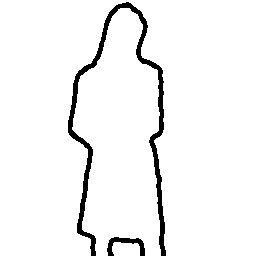

In [221]:
img = cv2.imread(filelist[0])
Image.fromarray(doOutline(img))

In [175]:
img_size = [64, 64]

In [176]:
edges_crop = get_edges(filelist, img_size, cropped=True, print_progress=True)
np.save('./clustering/features_edges_crop.npy', edges_crop)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000


In [177]:
edges = np.load('./clustering/features_edges.npy')
edges_smooth = np.load('./clustering/features_edges_smooth.npy')
edges_crop = np.load('./clustering/features_edges_crop.npy')

In [178]:
print(edges.shape)
print(edges_smooth.shape)
print(edges_crop.shape)

(63103, 64, 64)
(63103, 64, 64)
(63103, 64, 64)


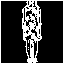

In [212]:
Image.fromarray(edges_smooth[4])

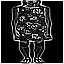

In [211]:
Image.fromarray(edges_crop[4])

# Cluster
Find clusters - usually whole model image, zoomed model image and detail images

In [181]:
X = edges_crop.reshape([edges_crop.shape[0], np.prod(edges_crop.shape[1:])])
X.shape

(63103, 4096)

In [182]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
joblib.dump(kmeans, './clustering/kmeans_edges_crop_4.pkl') 

['./clustering/kmeans_edges_crop_4.pkl']

##  Visualize Clusters

In [183]:
def plot_images_by_cluster(df_cluster, num_imgs, plot_center=False, cluster_centers=None):
    n_clusters = df_cluster.cluster.nunique()        
    imgs = df_cluster.groupby('cluster').agg({'path': 'unique'})
    
    ncols = num_imgs+1 if plot_center else num_imgs
    fig, axarr = plt.subplots(nrows=n_clusters, ncols=ncols, figsize=(2*num_imgs, 2*n_clusters))
    
    for cluster in imgs.index:
        cluster_imgs = imgs.loc[cluster, 'path'].tolist()
        print('Cluster {}: {} images'.format(cluster, len(cluster_imgs)))
        cluster_imgs = random.sample(cluster_imgs, num_imgs)
        
        plt_idx = 0
        if plot_center:
            ax = axarr[cluster][plt_idx]
            ax.axis('off')
            center = np.array(cluster_centers)[cluster]
            img = Image.fromarray(center.reshape(img_size))
            ax.imshow(img)
            plt_idx = 1
        
        for img_path in cluster_imgs:
            ax = axarr[cluster][plt_idx]
            ax.axis('off')
            img = Image.open(img_path)
            ax.imshow(img)
            plt_idx += 1
            
    plt.show()

In [184]:
def plot_cluster_centers(centers):
    
    fig=plt.figure(figsize=(4, 4))
    
    for idx, center in enumerate(centers):
        ax = fig.add_subplot(2, 2, idx+1)
        ax.axis('off')
        center = center.reshape(img_size)
        img = Image.fromarray(center)
        plt.imshow(img)
    plt.show()

In [106]:
def load_kmeans_model(path):
    kmeans = joblib.load(path)
    clusters = kmeans.labels_.tolist()
    centers = np.array(kmeans.cluster_centers_)
    
    return clusters, centers

In [185]:
kmeans2_clusters, kmeans2_centers = load_kmeans_model('./clustering/kmeans_edges_2.pkl')
kmeans3_clusters, kmeans3_centers = load_kmeans_model('./clustering/kmeans_edges_3.pkl')
kmeans4_clusters, kmeans4_centers = load_kmeans_model('./clustering/kmeans_edges_4.pkl')
kmeans4_crop_clusters, kmeans4_crop_centers = load_kmeans_model('./clustering/kmeans_edges_crop_4.pkl')

In [186]:
df2 = pd.DataFrame(list(zip(kmeans2_clusters, filelist)), columns=['cluster', 'path'])
df2.groupby('cluster').count()

,path
cluster,
0,10135
1,52968


In [187]:
df3 = pd.DataFrame(list(zip(kmeans3_clusters, filelist)), columns=['cluster', 'path'])
df3.groupby('cluster').count()

,path
cluster,
0,12960
1,41879
2,8264


In [188]:
df4 = pd.DataFrame(list(zip(kmeans4_clusters, filelist)), columns=['cluster', 'path'])
df4.groupby('cluster').count()

,path
cluster,
0,22933
1,22986
2,9427
3,7757


In [189]:
df4c = pd.DataFrame(list(zip(kmeans4_crop_clusters, filelist)), columns=['cluster', 'path'])
df4c.groupby('cluster').count()

,path
cluster,
0,21972
1,24377
2,10090
3,6664


## Cluster centers

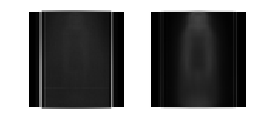

In [190]:
plot_cluster_centers(kmeans2_centers)

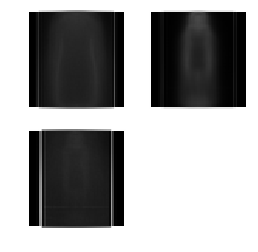

In [191]:
plot_cluster_centers(kmeans3_centers)

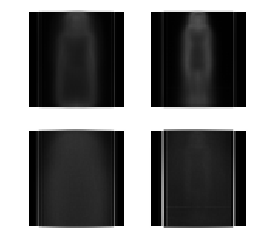

In [192]:
plot_cluster_centers(kmeans4_centers)

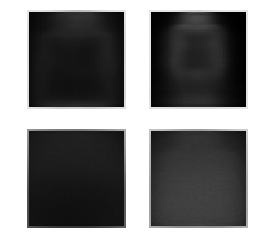

In [193]:
plot_cluster_centers(kmeans4_crop_centers)

## Plot random sample of images

Cluster 0: 10135 images
Cluster 1: 52968 images


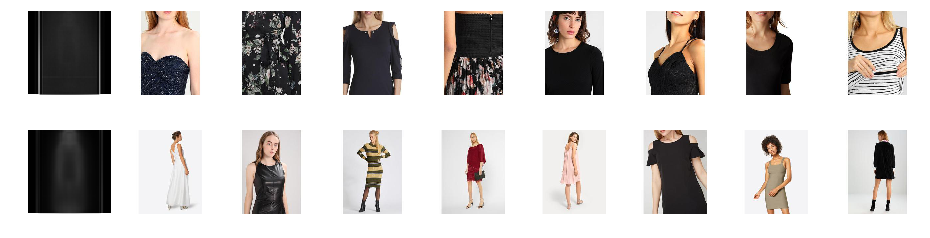

In [194]:
plot_images_by_cluster(df2, 8, plot_center=True, cluster_centers=kmeans2_centers)

Cluster 0: 12960 images
Cluster 1: 41879 images
Cluster 2: 8264 images


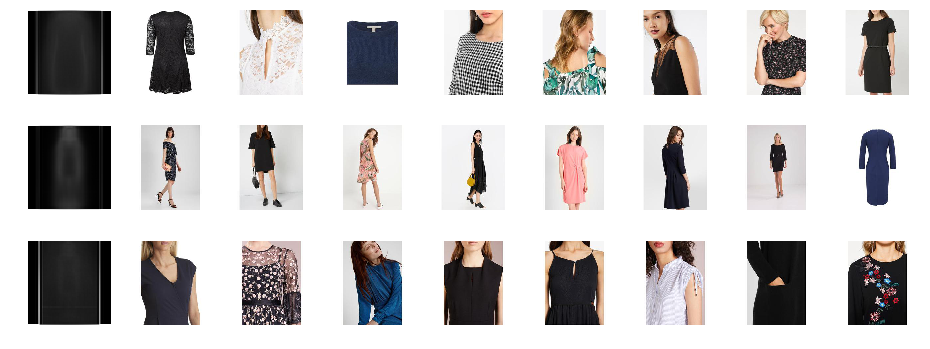

In [195]:
plot_images_by_cluster(df3, 8, plot_center=True, cluster_centers=kmeans3_centers)

Cluster 0: 22933 images
Cluster 1: 22986 images
Cluster 2: 9427 images
Cluster 3: 7757 images


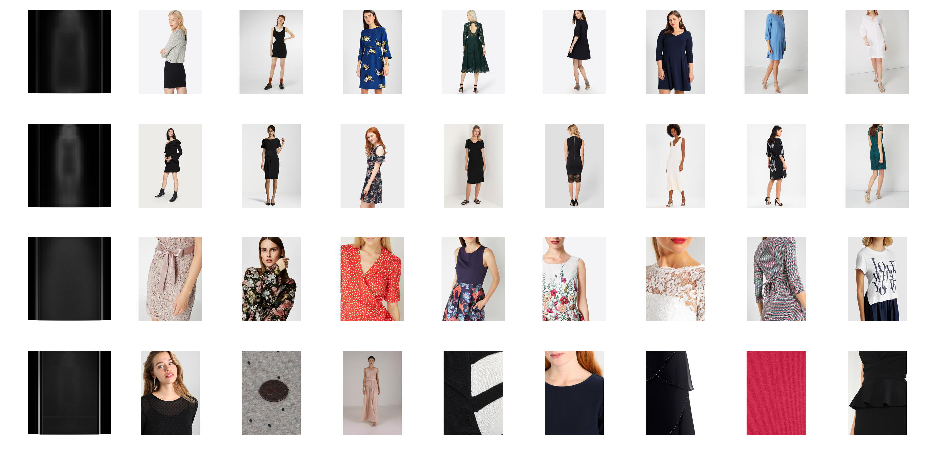

In [196]:
plot_images_by_cluster(df4, 8, plot_center=True, cluster_centers=kmeans4_centers)

Cluster 0: 21972 images
Cluster 1: 24377 images
Cluster 2: 10090 images
Cluster 3: 6664 images


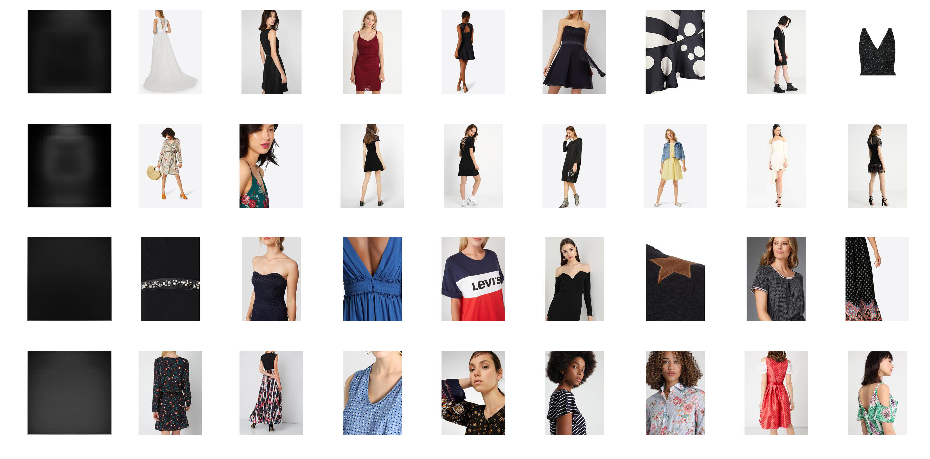

In [197]:
plot_images_by_cluster(df4c, 8, plot_center=True, cluster_centers=kmeans4_crop_centers)

## Select image for each product

In [198]:
def get_id_from_img_path(img_path):
    return os.path.basename(img_path).split('@')[0]

In [199]:
def plot_product_imgs(product_id, cluster_centers):
    product_files = [f for f in filelist if get_id_from_img_path(f) == product_id]
    features = get_edges(product_files, img_size)
    features = features.reshape(features.shape[0], np.prod(features.shape[1:]))
    
    dist = pairwise_distances(features, cluster_centers)
    img_clusters = dist.argmin(1)
    
    fig, axarr = plt.subplots(nrows=1, ncols=len(product_files), figsize=(len(product_files)*2, 2))
    
    for idx, product_file in enumerate(product_files):
        ax = axarr[idx]
        img = Image.open(product_file)
        ax.set_title(img_clusters[idx])
        ax.axis('off')
        ax.imshow(img)
    
    plt.show()

In [209]:
def plot_best_image_by_clusters(cluster_centers, product_id, smooth=False, crop=False):
    n_centers = len(cluster_centers)
    
    fig, axarr = plt.subplots(nrows=1, ncols=n_centers,
                              figsize=(n_centers*2, 2))

    product_files = [f for f in filelist if get_id_from_img_path(f) == product_id]
    edges = get_edges(product_files, img_size, smooth=smooth, cropped=crop)
    edges = edges.reshape(edges.shape[0], np.prod(edges.shape[1:]))

    dist = pairwise_distances(edges, cluster_centers)
    print(dist)
    imgs_idxs = dist.argmin(0)

    for idx, img_idx in enumerate(imgs_idxs):
        ax = axarr[idx]
        ax.axis('off')
        img = Image.open(product_files[img_idx])
        ax.imshow(img)

    plt.show()

In [201]:
product_ids = list(set([get_id_from_img_path(f) for f in filelist]))

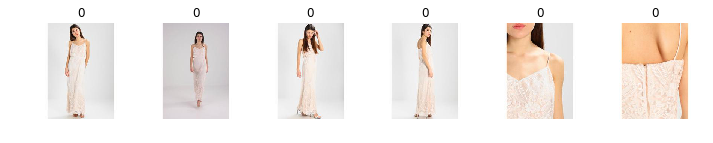

In [205]:
plot_product_imgs(product_ids[601], kmeans4_crop_centers)

[[ 2669.26126834  2795.90488487  3345.68797092  3616.28173062]
 [ 2429.35062919  2659.53051067  3133.92522826  3472.86646794]
 [ 2670.34623342  2781.05815749  3384.41700483  3588.5438643 ]
 [ 3056.76749231  3213.64265527  3299.97314164  3542.10132215]]


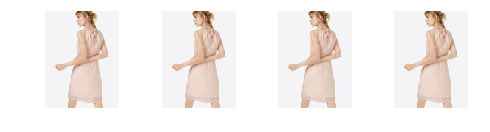

[[ 2612.23602408  2618.21385138  3296.14493493  3637.52477312]
 [ 2307.682388    2399.44721984  2893.15007485  3462.78711327]
 [ 2933.11781167  2902.25710049  3596.62431725  3843.45093019]
 [ 2392.12200709  2428.48338438  3172.88118752  3571.74918628]
 [ 2167.18590621  2374.16430508  2761.13675176  3273.8239419 ]
 [ 1768.4140117   2041.66385041  2567.3621653   2986.17185071]]


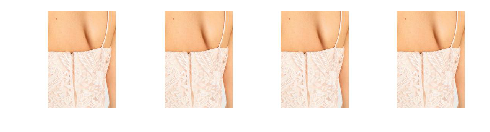

[[ 3854.05137936  4023.3820962   4316.55208603  4426.96659421]
 [ 3203.87007339  3058.76598643  3786.13981243  3992.85950688]
 [ 3543.50175692  3699.26359823  4129.46364719  4228.43499322]
 [ 3370.83441913  3413.96880515  4014.06952558  4105.24798751]
 [ 3629.44028798  3780.97104995  3187.64571422  4016.23132842]
 [ 3518.32497216  3797.77456867  2672.44492944  4102.30729192]]


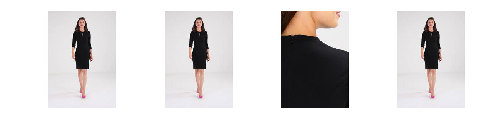

[[ 3697.20377221  3757.41800938  4286.27473428  4166.51030898]
 [ 4579.52349392  4756.42371637  3916.55535727  4449.73846376]
 [ 4019.04170844  4034.76745557  4570.08640512  4360.85334102]
 [ 4268.92116432  4314.82771665  4781.5594381   4540.26454372]]


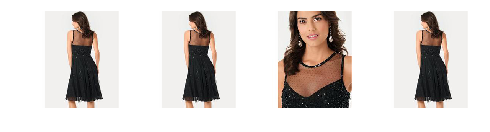

[[ 3083.27175084  3123.53557151  3678.41383661  3755.9865694 ]
 [ 3055.09457423  3024.69927723  3627.67835366  3685.19695004]
 [ 3082.09837555  3036.37037436  3684.85883134  3722.26466591]]


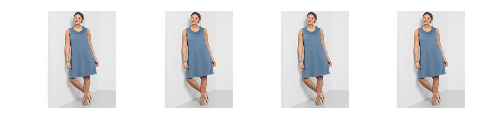

[[ 3131.60113789  3014.56348079  3847.38234075  3868.82562038]
 [ 5962.64034106  5967.39282763  6101.90094805  5457.68124786]
 [ 4766.03458612  4768.70032675  5146.74551115  4576.34974402]]


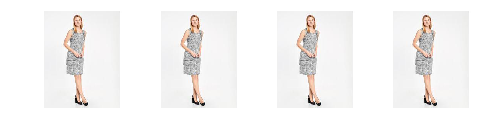

[[ 3635.29128478  3527.92136503  4157.71565621  4192.29895966]
 [ 3455.75963655  3375.47511383  3988.51465657  4092.50275597]
 [ 3976.02702628  4250.77160866  3505.23117221  4177.04737821]
 [ 3483.79113837  3817.46731854  2047.28400695  3910.93330479]]


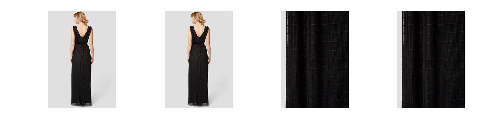

[[ 3887.12202398  3699.6209234   4389.33858494  4304.32035409]
 [ 3694.48546855  3635.60674038  4231.60046843  4219.47339073]
 [ 4073.29773764  4065.21134464  4505.14165346  4436.76609665]
 [ 4636.67102543  4782.40845718  4132.78401192  4437.47985755]
 [ 3524.66799215  3518.17925026  4078.32073914  4138.70127978]
 [ 3622.50969533  3578.8093796   4158.61736908  4106.15695287]]


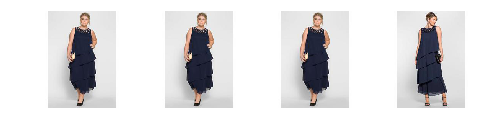

[[ 5652.09629557  5552.77309592  6007.92660578  5318.48152369]
 [ 3748.61833709  3620.14837166  4357.51946565  4268.02182126]
 [ 3664.35033715  3444.4898596   4303.50877669  4178.73328584]
 [ 6416.9683202   6428.36083638  6550.49987079  5956.5136582 ]]


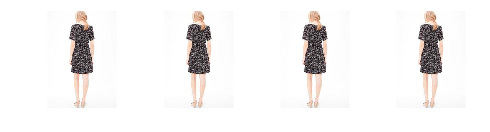

[[ 3330.37767737  3269.16360404  3878.08086601  3976.88244062]
 [ 3481.39825278  3471.50123331  4025.18764337  4070.8747351 ]
 [ 3498.66383024  3407.60250222  4032.42736875  4070.0774859 ]
 [ 4281.164603    4422.42749509  3892.58835215  4435.64839296]]


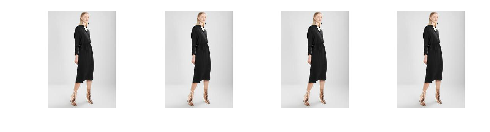

In [210]:
for product_id in product_ids[600:610]:
    plot_best_image_by_clusters(kmeans4_crop_centers, product_id, smooth=False, crop=True)